In [1]:
import cv2 as cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import time

In [2]:
print(cv2.__version__)

4.1.2


In [3]:
cat_img_path = os.path.join(os.getcwd(),'images','cat_1700.jpg')
print(cat_img_path)

C:\Users\paulmi\Desktop\MachineLearning\images\cat_1700.jpg


(333, 324, 3)


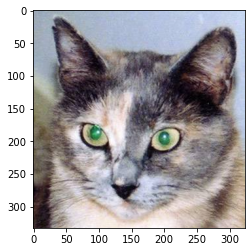

In [5]:
img = cv2.imread(cat_img_path)
print(img.shape)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = img[:,0:323,:]
plt.imshow(img)

In [33]:
def zero_pad(X, pad):
    """
    Pad with zeros the given X image. The padding is applied to the height and width of an image
    
    Argument:
    X -- python numpy array of shape (n_H, n_W, n_C) representing image
    pad -- integer, amount of padding around each image on vertical and horizontal dimensions
    
    Returns:
    X_pad -- padded image of shape (n_H + 2*pad, n_W + 2*pad, n_C)
    """
#     print(X.shape)
    X_pad = np.pad(X,((pad,pad),(pad,pad),(0,0)), mode='constant', constant_values = (0,0))
   
    
    return X_pad

In [34]:
def slice_conv(img_slice, kernel):
    """
    Apply one filter defined by parameters W on a single slice (a_slice_prev) of the input data (image)
   
    Arguments:
    image_slice -- slice of input data (image) of shape (f, f, n_C_prev)
    kernel -- kernel contained in a window - matrix of shape (f, f, n_C_prev)
    
    Returns:
    Z -- a scalar value, the result of convolving the sliding window fxf on a slice x of the input data (image)
    """
    # Element-wise product between img_slice and W. Do not add the bias yet.
    s = np.multiply(img_slice, kernel)
    # Sum over all entries of the volume s.
    Z = np.sum(s)

    return Z

In [35]:
def channel_slice_conv(img_slice, kernel):
    """
    Apply one filter defined by parameters W on a single slice (a_slice_prev) of the input data (image)
   
    Arguments:
    image_slice -- slice of input data (image) of shape (f, f, n_C_prev)
    kernel -- kernel contained in a window - matrix of shape (f, f, n_C_prev)
    
    Returns:
    Z -- a scalar value, the result of convolving the sliding window fxf on a slice x of the input data (image)
    """
    # Element-wise product between img_slice and W. Do not add the bias yet.
    s = np.multiply(img_slice, kernel)
    Z = np.sum(s,axis=(0,1))

    return Z

In [52]:
img_slice = img[300:303,100:103,:]
print(img_slice)
avg_kernel = np.full((3,3,3), fill_value=1/9)
print(channel_slice_conv(img_slice, avg_kernel))

[[[202 179 165]
  [195 169 154]
  [187 160 143]]

 [[213 186 175]
  [205 177 165]
  [198 169 153]]

 [[222 195 186]
  [218 190 179]
  [216 184 171]]]
[206.22222222 178.77777778 165.66666667]


In [41]:
def channel_wise_convolution(img,kernel):
    """
    Implements the convolution operation on the given image with the given kernel
    
    Arguments:
    img -- input image, numpy array of shape (n_H_prev, n_W_prev, n_C_prev)
    kernel -- numpy array of shape (f, f, n_C_prev)
        
    Returns:
    Z -- conv output, numpy array of shape (n_H, n_W, n_C)
    """
    
    # Retrieve dimensions from img's shape
    (n_H_prev, n_W_prev, n_C_prev) = img.shape
    
    # Retrieve dimensions from kernel's shape
    (f, f, n_C_prev) = kernel.shape
    
    stride = 1 # pixel by pixel convolution
    pad = int((f-1)/2) # 'same' convolution formula
    
    # Compute the dimensions of the CONV output of shape (n_H,n_W).  
    n_H = int((n_H_prev + 2*pad - f)/stride) + 1
    n_W = int((n_W_prev + 2*pad - f)/stride) + 1
    n_C = 3
    # Initialize the output volume Z with zeros. 
    Z = np.zeros((n_H,n_W,n_C))
    
    # Create img_pad by padding img    
    img_pad = zero_pad(img, pad)
    
    t0 = time.time()
    
    for h in range(n_H):           # loop over vertical axis of the output volume
        # Find the vertical start and end of the current "slice" 
        vert_start = h
        vert_end = h+f

        for w in range(n_W):       # loop over horizontal axis of the output volume
            # Find the horizontal start and end of the current "slice" 
            horiz_start = w
            horiz_end = w+f
            
            img_slice = img_pad[vert_start:vert_end,horiz_start:horiz_end,:]
            Z[h, w] = channel_slice_conv(img_slice[:,:], kernel)              
            
    t1 = time.time()

    total = t1-t0
    print("channel_wise_convolution time: ",total)
    # Making sure your output shape is correct
    assert(Z.shape == (n_H, n_W, n_C))    
    return Z 


In [42]:
def full_convolution(img,kernel):
    """
    Implements the convolution operation on the given image with the given kernel
    
    Arguments:
    img -- input image, numpy array of shape (n_H_prev, n_W_prev, n_C_prev)
    kernel -- numpy array of shape (f, f, n_C_prev)
        
    Returns:
    Z -- conv output, numpy array of shape (n_H, n_W, n_C)
    """
    
    # Retrieve dimensions from img's shape
    (n_H_prev, n_W_prev, n_C_prev) = img.shape
    
    # Retrieve dimensions from kernel's shape
    (f, f, n_C_prev) = kernel.shape
    
    stride = 1 # pixel by pixel convolution
    pad = int((f-1)/2) # 'same' convolution formula
    
    # Compute the dimensions of the CONV output of shape (n_H,n_W).  
    n_H = int((n_H_prev + 2*pad - f)/stride) + 1
    n_W = int((n_W_prev + 2*pad - f)/stride) + 1
    
    # Initialize the output volume Z with zeros. 
    Z = np.zeros((n_H,n_W))
    
    # Create img_pad by padding img    
    img_pad = zero_pad(img, pad)
    
    t0 = time.time()
    
    for h in range(n_H):           # loop over vertical axis of the output volume
        # Find the vertical start and end of the current "slice" 
        vert_start = h
        vert_end = h+f

        for w in range(n_W):       # loop over horizontal axis of the output volume
            # Find the horizontal start and end of the current "slice" 
            horiz_start = w
            horiz_end = w+f
            
            img_slice = img_pad[vert_start:vert_end,horiz_start:horiz_end,:]
            Z[h, w] = slice_conv(img_slice, kernel)
            
    t1 = time.time()

    total = t1-t0
    print("full_convolution time: ",total)
    # Making sure your output shape is correct
    assert(Z.shape == (n_H, n_W))    
    return Z 

In [60]:
simple_box_3_all_kernel = np.full((5,5,3), fill_value=1/25)
# sobel_3_all
# x_rand = np.random.randn(5,5,3)
# print(simple_box_3_all)
# simple_box_3_all_img = full_convolution(img,simple_box_3_all_kernel)
simple_box_3_cw_img = channel_wise_convolution(img,simple_box_3_all_kernel)/255



channel_wise_convolution time:  2.2037882804870605


[[[0.79105882 0.69819608 0.64564706]
  [0.77427451 0.67701961 0.61756863]
  [0.75639216 0.65505882 0.59043137]]

 [[0.824      0.7254902  0.68141176]
  [0.808      0.70462745 0.65176471]
  [0.78635294 0.67843137 0.61788235]]

 [[0.85160784 0.752      0.71121569]
  [0.83529412 0.73192157 0.68109804]
  [0.81521569 0.70729412 0.64831373]]]


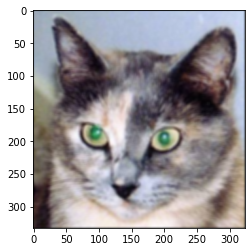

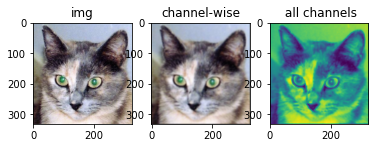

In [61]:
# print(simple_box_3_cw_img.shape)
# print(simple_box_3_cw_img[0:4,0:3,1])
# print(simple_box_3_all_img.shape)
# print(simple_box_3_all_img[0:4,0:3])
print(simple_box_3_cw_img[300:303,100:103,:])
plt.imshow(simple_box_3_cw_img)
fig, axarr = plt.subplots(1, 3)
axarr[0].set_title('img')
axarr[0].imshow(img[:,:,:])
axarr[1].set_title('channel-wise')
axarr[1].imshow(simple_box_3_cw_img[:,:,:]),
axarr[2].set_title(' all channels')
axarr[2].imshow(simple_box_3_all_img[:,:])
